In [671]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from datatools import DataGrapher


%matplotlib inline

In [672]:
#Bring in the data

nba = pd.read_csv('./data/nba_analysis_data.csv')
nba.dropna(inplace = True)

In [673]:
#seperate test from train

nba_train = nba[nba.test == 0]
nba_test = nba[nba.test ==1]  #scott tarlow scotttarlow@gmail.com
#learn a domain

In [674]:
nba_train = nba_train[nba_train.playoff_game == 1]
nba_test = nba_test[nba_test.playoff_game == 1]

In [675]:

X_train = nba_train.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'         ])


#X = nba[features]
y_train = nba_train['cover']

In [676]:
X_test= nba_test.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'       ])

y_test = nba_test.away_cover

In [677]:

X_test.shape

(150, 148)

In [678]:
X_train.shape

(711, 148)

### Interaction Terms

At one point in the modeling process I hoped to get better results by including some interactions in the model.  They did not appear significant and added noise so they were removed, but I left the code in case I wanted to reinsert them later. 

In [679]:

# #create interactions  tested but did not help the model
# poly = PolynomialFeatures(degree = 2, interaction_only= True)
# X_poly = poly.fit_transform(X_train)
# X_poly_test = poly.transform(X_test)
# X_poly = pd.DataFrame(X_poly, 
#                       columns = poly.get_feature_names(X_train.columns))
# X_poly_test = pd.DataFrame(X_poly_test, 
#                            columns = poly.get_feature_names(X_test.columns))


### Scale and Transform the data

I use standard scaler scale the data and then do a principal components analysis to transform the data.  I do not care about inference in this case only prediction and there is a good deal of correlation between variables. So I decided to transform the data to reduce the number and get orthoginal features without losing much information.  I retain 99% of the variance.

In [680]:

#scaling data to use in various other methods
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [681]:
from sklearn.decomposition import PCA

In [682]:
pc = PCA(n_components=70)
X_train_pc = pc.fit_transform(X_train_scaled)
X_test_pc = pc.transform(X_test_scaled)


In [683]:
var_exp = pc.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [0.11834685 0.104883   0.06266254 0.04411775 0.04018636 0.03734666
 0.03476068 0.03171364 0.03139363 0.02753802 0.02744268 0.02399141
 0.02344819 0.01998734 0.01883975 0.01781687 0.01662342 0.01571055
 0.01524122 0.01448081 0.01423059 0.01298795 0.01231318 0.01210623
 0.01140447 0.0102714  0.01001335 0.00975316 0.00923449 0.00848232
 0.00833255 0.00792014 0.00744979 0.00729155 0.00692119 0.00671727
 0.00622452 0.00601655 0.00566995 0.00522665 0.00491279 0.00467794
 0.00460015 0.00420859 0.00404255 0.003902   0.00363442 0.00344472
 0.00337061 0.00319925 0.00308048 0.00296615 0.00273094 0.00265915
 0.0025538  0.00241487 0.00232505 0.00208454 0.00199289 0.00193616
 0.00187553 0.00182429 0.0016813  0.00159422 0.00149084 0.00140558
 0.00137027 0.00133912 0.00128009 0.00116461]
Cumulative explained variance:  [0.11834685 0.22322985 0.28589239 0.33001014 0.3701965  0.40754316
 0.44230384 0.47401748 0.5054111  0.53294913 0.5603918  0.58438321
 0.6078314  0.62781

### Logistic Regression

The first model I tested out was the logistic regression on good thing about the NBA data is that much of the data seemed to be normally distributed and my transformed features are uncorrelated so I thought

In [684]:
lr = LogisticRegressionCV(Cs = [100000],
                         max_iter=1000,
                         penalty = 'l1',
                         tol = .00001,
                         solver ='saga' )


lr.fit(X_train_pc, y_train)
print(lr.score(X_train_pc, y_train))


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6497890295358649


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [685]:
lr.score(X_test_pc, y_test)

0.5466666666666666

In [686]:
y_hat_lr   = lr.predict(X_train_pc)
y_hat_lrp  = lr.predict_proba(X_train_pc)
y_hat_lrt  = lr.predict(X_test_pc)
y_hat_lrtp = lr.predict_proba(X_test_pc)

In [687]:
print(classification_report(y_train, y_hat_lr))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       333
           1       0.66      0.69      0.68       378

   micro avg       0.65      0.65      0.65       711
   macro avg       0.65      0.65      0.65       711
weighted avg       0.65      0.65      0.65       711



In [688]:
print(classification_report(y_test, y_hat_lrt))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59        73
           1       0.58      0.43      0.49        77

   micro avg       0.55      0.55      0.55       150
   macro avg       0.55      0.55      0.54       150
weighted avg       0.55      0.55      0.54       150



In [689]:
confusion_matrix( y_train, y_hat_lr)

array([[201, 132],
       [117, 261]])

In [690]:
confusion_matrix( y_test, y_hat_lrt)

array([[49, 24],
       [44, 33]])

### Support Vector Machine

The second model I tested is the Support Vector Machine Model I 

In [726]:
svc = SVC(probability=True)
svc_params = {
    'kernel' : ['linear'  ], 
    'C'      : [.1, .2, .3]
    }

In [727]:
gs = GridSearchCV(svc, 
                  param_grid=svc_params, 
                  scoring='precision', 
                  cv = 5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.5654114107668061
{'C': 0.2, 'kernel': 'linear'}


In [728]:
gs.score(X_test_pc, y_test)

0.5967741935483871

In [729]:
#predict categories and  probabilities for svc model

y_hat_svc   = gs.predict(X_train_pc)
y_hat_svcp  = gs.predict_proba(X_train_pc)
y_hat_svct  = gs.predict(X_test_pc)
y_hat_svctp = gs.predict_proba(X_test_pc)

In [730]:
print(classification_report(y_train, y_hat_svc))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       333
           1       0.68      0.72      0.70       378

   micro avg       0.67      0.67      0.67       711
   macro avg       0.67      0.67      0.67       711
weighted avg       0.67      0.67      0.67       711



In [731]:
print(classification_report(y_test, y_hat_svct))

              precision    recall  f1-score   support

           0       0.55      0.66      0.60        73
           1       0.60      0.48      0.53        77

   micro avg       0.57      0.57      0.57       150
   macro avg       0.57      0.57      0.56       150
weighted avg       0.57      0.57      0.56       150



In [732]:
confusion_matrix( y_train, y_hat_svc)

array([[206, 127],
       [106, 272]])

In [733]:
confusion_matrix( y_test, y_hat_svct)

array([[48, 25],
       [40, 37]])

### Neural Network

I also wanted to try fitting a neural network.  I do not care about the inference implications, but I found that the neural network had to much variance depending on starting weights so I decided not to use it in predictions.  

In [734]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import regularizers

In [737]:
model = Sequential()
model.add(Dense(70, 
                activation = 'relu',
                input_dim = X_train_pc.shape[1],
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.8))

#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer 

In [738]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
model.fit(X_train_pc, 
          y_train, epochs =50, 
          batch_size= 128, 
          validation_data=(X_test_pc, y_test))

Train on 711 samples, validate on 150 samples
Epoch 1/50
711/711 [==============================] - 1s 1ms/step - loss: 2.1942 - acc: 0.4726 - val_loss: 1.5634 - val_acc: 0.4733
Epoch 2/50
711/711 [==============================] - 0s 16us/step - loss: 2.0319 - acc: 0.5007 - val_loss: 1.5276 - val_acc: 0.4867
Epoch 3/50
711/711 [==============================] - 0s 18us/step - loss: 1.9799 - acc: 0.5134 - val_loss: 1.4931 - val_acc: 0.4867
Epoch 4/50
711/711 [==============================] - 0s 23us/step - loss: 1.9192 - acc: 0.5134 - val_loss: 1.4607 - val_acc: 0.5000
Epoch 5/50
711/711 [==============================] - 0s 20us/step - loss: 1.8720 - acc: 0.5021 - val_loss: 1.4290 - val_acc: 0.4867
Epoch 6/50
711/711 [==============================] - 0s 18us/step - loss: 1.7459 - acc: 0.5176 - val_loss: 1.3982 - val_acc: 0.4867
Epoch 7/50
711/711 [==============================] - 0s 18us/step - loss: 1.7280 - acc: 0.5288 - val_loss: 1.3701 - val_acc: 0.5067
Epoch 8/50
711/711 [====

In [702]:
#returns a probability

y_hat_nnp = model.predict(X_train_pc)
y_hat_nntp = model.predict(X_test_pc)


In [747]:
rf = RandomForestClassifier()
rf_params = {'n_estimators'      : [70],
             'max_depth'         : [50],
             'min_samples_split' : [120],
             'min_samples_leaf'  : [10] }

gs1 = GridSearchCV(rf, 
                  param_grid=rf_params,
                  scoring='precision',
                 cv =5)
gs1.fit(X_train_pc, y_train)
print(gs1.best_score_)
print(gs1.best_params_)



0.5435498006135896
{'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 120, 'n_estimators': 70}


In [748]:
gs1.score(X_test_pc, y_test)

0.5607476635514018

In [749]:
y_hat_rf   = gs1.predict(X_train_pc)
y_hat_rfp  = gs1.predict_proba(X_train_pc)
y_hat_rft  = gs1.predict(X_test_pc)
y_hat_rftp = gs1.predict_proba(X_test_pc)

In [750]:
print(classification_report(y_train, y_hat_rf))

              precision    recall  f1-score   support

           0       0.95      0.64      0.76       333
           1       0.75      0.97      0.85       378

   micro avg       0.81      0.81      0.81       711
   macro avg       0.85      0.80      0.80       711
weighted avg       0.84      0.81      0.81       711



In [751]:
print(classification_report(y_test, y_hat_rft))

              precision    recall  f1-score   support

           0       0.60      0.36      0.45        73
           1       0.56      0.78      0.65        77

   micro avg       0.57      0.57      0.57       150
   macro avg       0.58      0.57      0.55       150
weighted avg       0.58      0.57      0.55       150



In [752]:
confusion_matrix( y_train, y_hat_rf)

array([[212, 121],
       [ 12, 366]])

In [753]:
confusion_matrix( y_test, y_hat_rft)

array([[26, 47],
       [17, 60]])

In [757]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves 
#Random Forest
nba_train.loc[:, 'actual_y'] = y_train
nba_train.loc[:, 'predicted_label_rf'] = y_hat_rf
nba_train.loc[:, 'predicted_proba_rfp'] = y_hat_rfp[:, 1]

#SVC

nba_train.loc[:, 'predicted_label_svc'] = y_hat_svc
nba_train.loc[:, 'predicted_proba_svcp'] = y_hat_svcp[:, 1]

#Logistic
nba_train.loc[:, 'predicted_label_lr'] = y_hat_lr
nba_train.loc[:, 'predicted_proba_lrp'] = y_hat_lrp[:, 1]



In [758]:
#Random Forest
nba_test.loc[:, 'actual_y'] = y_test
nba_test.loc[:, 'predicted_label_rf'] = y_hat_rft
nba_test.loc[:, 'predicted_proba_rfp'] = y_hat_rftp[:, 1]

#SVC

nba_test.loc[:, 'predicted_label_svc'] = y_hat_svct
nba_test.loc[:, 'predicted_proba_svcp'] = y_hat_svctp[:, 1]

#Logistic
nba_test.loc[:, 'predicted_label_lr'] = y_hat_lrt
nba_test.loc[:, 'predicted_proba_lrp'] = y_hat_lrtp[:, 1]



#Neural Network
nba_test.loc[:, 'predicted_proba_nnp'] = y_hat_nntp
nba_test.loc[:, 'predicted_label_nn'] = nba_test.predicted_proba_nnp.map(
                lambda x: 0 if x<=.5 else 1)





In [759]:
print(nba_test.groupby(['predicted_label_svc'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_svc'])['home_payout'].sum())

predicted_label_svc
0   -10.640
1     9.633
Name: away_payout, dtype: float64
predicted_label_svc
0     2.723
1   -15.184
Name: home_payout, dtype: float64


In [760]:
print(nba_test.groupby(['predicted_label_lr'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_lr'])['home_payout'].sum())

predicted_label_lr
0   -8.004
1    6.997
Name: away_payout, dtype: float64
predicted_label_lr
0    -0.368
1   -12.093
Name: home_payout, dtype: float64


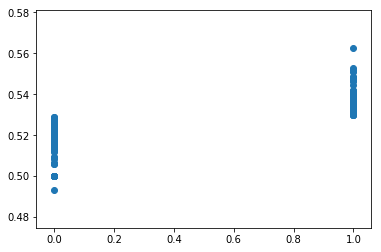

In [715]:
plt.scatter(nba_test.predicted_label_svc, nba_test.predicted_proba_svcp)

In [761]:
from sklearn.metrics import roc_curve, auc

In [762]:
fpr, tpr, _ = roc_curve(y_test, nba_test['predicted_proba_lrp'])
roc_auc = auc(fpr, tpr)

In [763]:
fpr1, tpr1, _ = roc_curve(y_test, nba_test['predicted_proba_svcp'])
roc_auc1 = auc(fpr1, tpr1)

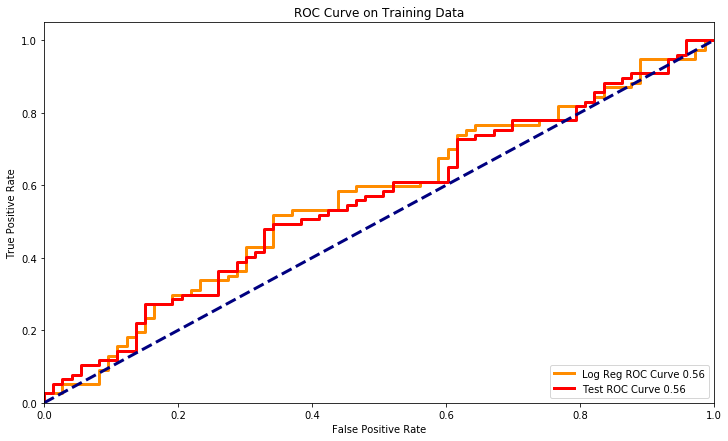

In [764]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", 
         label = "Log Reg ROC Curve %.2f" % roc_auc)
plt.plot(fpr1, tpr1, lw = line_width, color="red", 
         label = "Test ROC Curve %.2f" % roc_auc1)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc="lower right")
plt.show()

In [720]:
for prob in range(40, 60, 1):
    proba = prob/100
    
    nba_test.loc[:, 'predicted_label_lr']= nba_test['predicted_proba_lrp'].map(
        lambda p: 1 if p >= proba else 0)
    
    nba_test.loc[:, 'predicted_label_svc']= nba_test['predicted_proba_svcp'].map(
        lambda p: 1 if p >= proba else 0)
    

    
    print('Test Logistic Regression :' + str(proba))

    print ("Return of Away Games: ", nba_test.groupby(
        "predicted_label_lr").away_payout.sum())
    print ("Return of Home Games: ", nba_test.groupby(
        "predicted_label_lr").home_payout.sum())
    
    print (" ")
   
    print('Test SVC :' + str(proba))    
    print ("Return of Away Games SVC: ", nba_test.groupby(
        "predicted_label_svc").away_payout.sum())
    print ("Return of Home Games SVC: ", nba_test.groupby(
        "predicted_label_svc").home_payout.sum())
    print("")
    
  

Test Logistic Regression :0.4
Return of Away Games:  predicted_label_lr
0   -2.821
1    1.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0   -2.821
1   -9.640
Name: home_payout, dtype: float64
 
Test SVC :0.4
Return of Away Games SVC:  predicted_label_svc
1   -1.007
Name: away_payout, dtype: float64
Return of Home Games SVC:  predicted_label_svc
1   -12.461
Name: home_payout, dtype: float64

Test Logistic Regression :0.41
Return of Away Games:  predicted_label_lr
0   -5.821
1    4.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0    -0.094
1   -12.367
Name: home_payout, dtype: float64
 
Test SVC :0.41
Return of Away Games SVC:  predicted_label_svc
1   -1.007
Name: away_payout, dtype: float64
Return of Home Games SVC:  predicted_label_svc
1   -12.461
Name: home_payout, dtype: float64

Test Logistic Regression :0.42
Return of Away Games:  predicted_label_lr
0   -6.821
1    5.814
Name: away_payout, dtype: float64
Return of H

In [721]:
    nba_test.loc[:, 'predicted_label']= nba_test['predicted_proba_lrp'].map(
    lambda p: 1 if .52 < proba else 0)
    
    nba_test.loc[:, 'predicted_label1']= nba_test['predicted_proba_svcp'].map(
    lambda p: 1 if .52 < proba else 0)

In [722]:
#Combined 
nba_test['vote'] = nba_test.predicted_label_svc + nba_test.predicted_label_lr
              

In [723]:
nba_test.vote.value_counts(normalize = True)

0    0.76
1    0.24
Name: vote, dtype: float64

In [724]:
nba_test.groupby(['vote'])['away_payout'].sum()

vote
0   -7.005
1    5.998
Name: away_payout, dtype: float64

In [725]:
nba_test.groupby(['vote'])['home_payout'].sum()

vote
0   -3.187
1   -9.274
Name: home_payout, dtype: float64